In [282]:
## Import scripts for the dimension reduction methods 
import IHPF
import INMF 
import schpf
from sklearn.decomposition import PCA

In [283]:
from scipy.sparse import coo_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData

In [284]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn import preprocessing

In [285]:
import seaborn as sb
import matplotlib.pyplot as plt
sb.set(font_scale=1.25)

In [319]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc']

methods = ['IHPF','INMF','PCA']

### BHI analysis

- prepare gene clusters csv for the scenarios 
- Run BHI jobs on R cluster
- Check why there are missing mappings 
- Copy the zscores to the spreadsheet 
- Compare BHI scores for IHPF, INMF and PCA 

- Show the Clustering from INMF and PCA are NOT balance by SC and CH scores 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html#sklearn.metrics.calinski_harabasz_score

- K-Means Clustering on the normalised gene scores for INMF and PCA works. For fair compairison we normalise IHPF gene scores also before k-means clustering 

- What are the p-values for the zscores obtained from BHI (One sided t-test) 

In [291]:
from sklearn.metrics import calinski_harabasz_score

In [299]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc']

methods = ['IHPF','INMF','PCA']

gene_SC = dict()


label_no = {'10Xmouse':'Scenario A','humanpancreas':'Scenario B','10Xpbmc':'Scenario C'}
for dataset in datasets:
    adata = sc.read('../Data/{}_v4_processed.h5ad'.format(dataset))
    for method in methods:
        output = pd.DataFrame(index=adata.var.index)
        for k in range(2,11,1):
            if method == 'IHPF':
                if dataset == '10Xmouse':
                    methodname = 'IHPF_0.001'
                if dataset == 'humanpancreas':
                    methodname = 'IHPF_0.5'
                if dataset == '10Xpbmc':
                    methodname = 'IHPF_0.01'
            else:
                methodname = method
            kmeans_gene = KMeans(n_clusters=k, random_state=0).fit(normalize(adata.varm[methodname]))
            adata.var['{}_kmeans_normalised_{}'.format(method,k)] = kmeans_gene.labels_
            output['{}_{}'.format(method,k)] = kmeans_gene.labels_
            gene_SC[(label_no[dataset],method,k)] = silhouette_score(adata.varm['{}'.format(methodname)],kmeans_gene.labels_,)
            output.to_csv('outputs/{}_{}_gene_cluster_v5.csv'.format(method,dataset))   

In [ ]:
gene_SC_results_ = np.round(pd.Series(gene_SC),3)  
gene_SC_results = gene_SC_results_.reset_index()

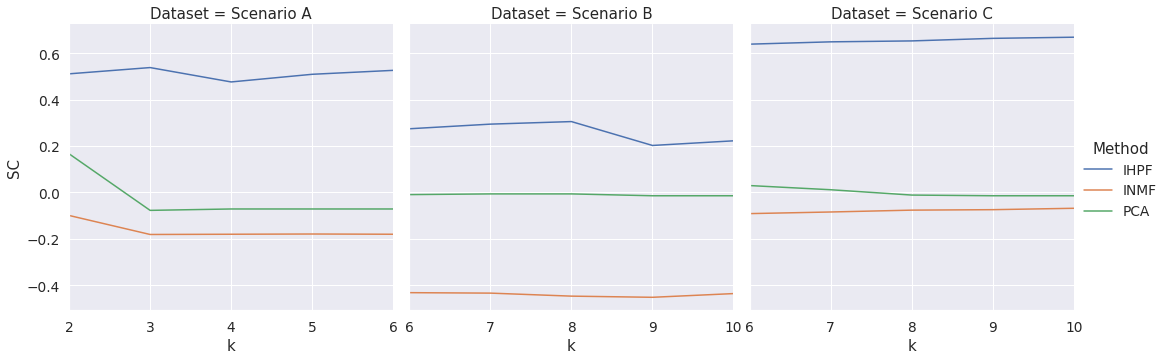

In [313]:
gene_SC_results.columns = ['Dataset','Method','k','SC']
SC_plot = sb.relplot(
    data=gene_SC_results, x="k", y="SC",
    col="Dataset", hue="Method",
    kind="line", facet_kws=dict(sharex=False),
)
SC_plot.axes[0,0].set_xlim(2,6)
SC_plot.axes[0,1].set_xlim(6,10)
SC_plot.axes[0,2].set_xlim(6,10)
SC_plot.savefig('../Result/Gene_SC_v9.pdf',format='pdf')

In [301]:
gene_SC_results.to_csv('../Result/gene_SC_v9.csv',index=False)

In [302]:
datasets = ['10Xmouse','humanpancreas','10Xpbmc']

methods = ['IHPF','INMF','PCA']

cell_SC = dict()

label_no = {'10Xmouse':'Scenario A','humanpancreas':'Scenario B','10Xpbmc':'Scenario C'}
for dataset in datasets:
    adata = sc.read('../Data/{}_v4_processed.h5ad'.format(dataset))
    for method in methods:
        for k in range(2,11,1):
            if method == 'IHPF':
                if dataset == '10Xmouse':
                    methodname = 'IHPF_0.001'
                if dataset == 'humanpancreas':
                    methodname = 'IHPF_0.5'
                if dataset == '10Xpbmc':
                    methodname = 'IHPF_0.01'
            else:
                methodname = method
            kmeans_cell = KMeans(n_clusters=k, random_state=0).fit(normalize(adata.obsm[methodname]))
            adata.obs['{}_kmeans_normalised_{}'.format(method,k)] = kmeans_cell.labels_
            cell_SC[(label_no[dataset],method,k)] = silhouette_score(adata.obsm['{}'.format(methodname)],kmeans_cell.labels_,)

In [303]:
cell_SC_results_ = np.round(pd.Series(cell_SC),3)

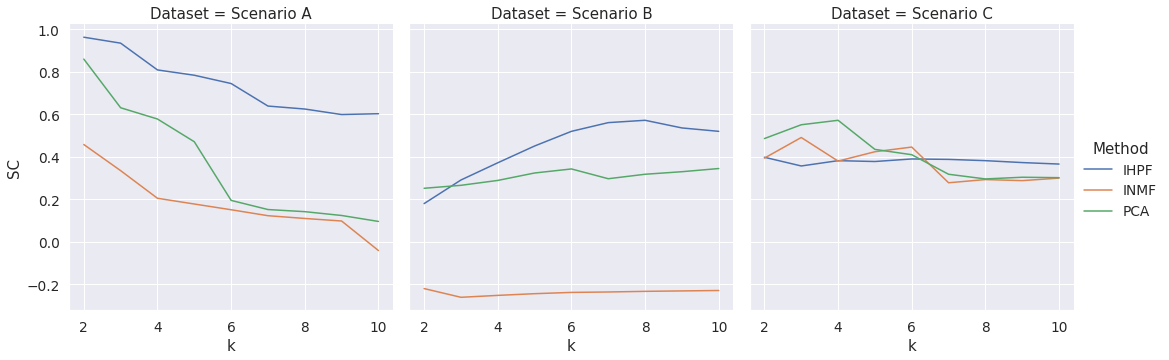

In [304]:
cell_SC_results = cell_SC_results_.reset_index()
cell_SC_results.columns = ['Dataset','Method','k','SC']
SC_plot = sb.relplot(
    data=cell_SC_results, x="k", y="SC",
    col="Dataset", hue="Method",
    kind="line"
)
SC_plot.savefig('../Result/Cell_SC_v9.pdf',format='pdf')

### GO Terms 

In [314]:
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo



In [315]:
from goatools.base import download_ncbi_associations
fin_gene2go = download_ncbi_associations()

FTP RETR ftp.ncbi.nlm.nih.gov gene/DATA gene2go.gz -> gene2go.gz
  gunzip gene2go.gz


In [316]:
from goatools.obo_parser import GODag

obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2022-07-01) 47,008 GO Terms


In [317]:
from goatools.anno.genetogo_reader import Gene2GoReader

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606,10090])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc({9606, 10090})

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated mouse genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:11.641843 784,953 annotations, 50,575 genes, 20,071 GOs, 2 taxids READ: gene2go 
CC 39,237 annotated mouse genes
BP 37,578 annotated mouse genes
MF 35,782 annotated mouse genes


In [ ]:
GeneID2nt = pd.concat([GeneID2nt_mus, GeneID2nt_hum])

In [320]:
import mygene

In [321]:
mg = mygene.MyGeneInfo()

In [322]:
def goea(important_genes, species='mouse'):
    mouseIHPF_gene_score_ensemble_df = mg.querymany(important_genes.index, scopes='symbol',as_dataframe=True, fields=['unigene','entrezgene', 'name', 'notfound', 'symbol', 'taxid'], species=species)
    mouseIHPF_map = mouseIHPF_gene_score_ensemble_df.dropna(subset=['unigene'])
    mouseIHPF_geneids = list()
    for s in mouseIHPF_map['unigene']:
        if type(s) == list:
            for t in s:
                temp = t.split('.')[-1]
                mouseIHPF_geneids.append(int(temp))
        else:
            temp = s.split('.')[-1]
            mouseIHPF_geneids.append(int(temp))
    if species == 'mouse':
        goea_results_all = goeaobj_mus.run_study(mouseIHPF_geneids)
    else:
        goea_results_all = goeaobj_hum.run_study(mouseIHPF_geneids)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    goea_results_sig_2 = [vars(x) for x in goea_results_all]
    return pd.DataFrame(goea_results_sig_2)

In [332]:
GO_clusters = list()
for dataset in ['10Xmouse']:
    batch_labels = 'batch'
    cell_labels = 'actual'        
    batch = dict()
    actual = dict()
    adata = sc.read('../Data/{}_v4_processed.h5ad'.format(dataset))
    #k = adata.varm['IHPF'].shape[1]
    k=3
    kmeans_gene = KMeans(n_clusters=k, random_state=0).fit(adata.varm['IHPF_0.001'])
    adata.var['Gene_Clusters'] = kmeans_gene.labels_
    for i in range(0,k):
        cluster_gene  = adata.var[adata.var['Gene_Clusters']==i]
        if dataset == '10Xmouse':
            species = 'mouse'
        else:
            species = 'human'
        GO_cluster = goea(cluster_gene,species)
        GO_cluster['dataset'] = dataset
        GO_cluster['cluster'] = i
        GO_clusters.append(GO_cluster)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-8059...done.
Finished.
7 input query terms found dup hits:
	[('CDR1', 2), ('CFHR3', 2), ('EPPK1', 2), ('LCN15', 2), ('NRG1', 2), ('RNU11', 2), ('UBE2NL', 2)]
2833 input query terms found no hit:
	['A2M-AS1', 'ABCA10', 'ABCB1', 'ABCC11', 'AC002076.10', 'AC002117.1', 'AC002310.7', 'AC002456.2', 'A
Pass "returnall=True" to return complete lists of duplicate or missing query terms.

Run BP Gene Ontology Analysis: current study set of 6092 IDs ... 86%    234 of    273 study items found in association
  4%    273 of  6,092 study items found in population(26382)
Calculating 12,524 uncorrected p-values using fisher_scipy_stats
  12,524 GO terms are associated with 17,557 of 26,382 population items
   1,421 GO terms are associated with    234 of  6,057 study items
  METHO

In [333]:
GOs = pd.concat(GO_clusters)

In [334]:
GOs[GOs['p_fdr_bh']<=0.05].groupby(['dataset','cluster']).count()

GO  name  NS  depth  method_flds  kws  p_uncorrected  \
dataset  cluster                                                         
10Xmouse 0         3     3   3      3            3    3              3   
         1        15    15  15     15           15   15             15   

                  study_items  pop_items  ratio_in_study  ratio_in_pop  \
dataset  cluster                                                         
10Xmouse 0                  3          3               3             3   
         1                 15         15              15            15   

                  study_count  study_n  pop_count  pop_n  enrichment  goterm  \
dataset  cluster                                                               
10Xmouse 0                  3        3          3      3           3       3   
         1                 15       15         15     15          15      15   

                  p_fdr_bh  
dataset  cluster            
10Xmouse 0               3  
         1              15

In [335]:
GOs[GOs['p_fdr_bh']<=0.05][['GO','name','p_fdr_bh','dataset','cluster']].to_csv('10Xmouse_GO_example.csv',index=False)

In [338]:
GO_tops = list()

for i,df in GOs.groupby(['dataset','cluster']):

    GO_tops.append(df.sort_values('p_fdr_bh').head())

In [340]:
pd.concat(GO_tops)[['GO','name','p_fdr_bh','dataset','cluster']].to_csv('10Xmouse_GO_IHPF.csv',index=False)